<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>

# 4. Classifier-Free Diffusion Guidance

So far, we have been able to train a model to generate images of clothing using the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. However, there is no way for the user to specify what kind of images should be generated. Let's fix that by creating a [Conditional Diffusion Model](https://github.com/TeaPearce/Conditional_Diffusion_MNIST/tree/main). We will later improve the performace by using [Classifier-Free Diffusion Guidance](https://arxiv.org/pdf/2207.12598.pdf).

#### Learning Objectives

The goals of this notebook are to:
* Add categorical embeddings to a U-Net
* Train a model with a Bernoulli mask
* Add a weight the reverse diffusion process
* Practice learnings on a more challenging dataset


Before we get started, let's load the necessary libraries and dataset information.

In [1]:
import glob
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid

# User defined libraries
from utils import other_utils
from utils import ddpm_utils
from utils import UNet_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
IMG_SIZE = 16
IMG_CH = 1
BATCH_SIZE = 128
N_CLASSES = 10
data, dataloader = other_utils.load_transformed_fashionMNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 4.1 Model Training

Our `B`eta schedule from before will stay the same.

In [3]:
nrows = 10
ncols = 15

T = nrows * ncols
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = ddpm_utils.DDPM(B, device)

This time, our `UNet` is slightly different. We've added a few changes and moved the U-Net architecture into its own [UNet_utils.py](utils/UNet_utils.py) folder.

In the `__init__` function, we've added a new parameter: `c_embed_dim`. Like for timestep `t`, we can create an embedding for our class categories.

```python
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.t_emb1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.t_emb2 = EmbedBlock(t_embed_dim, up_chs[1])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[0])  # New
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[1])  # New
```

Next, in the `forward` function, we have two new parameters: `c` and `c_mask`.
* `c` is a vector representing our categorical input. It can be a [one-hot encoding](https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding) or an embedding vector.
* `c_mask` is used to randomly set values within `c` to zero. This helps the model learn what an average output might be without a categorical input, like in the previous notebook. 

```python
        c = c * c_mask
        c_emb1 = self.c_embed1(c)
        c_emb2 = self.c_embed2(c)
```

There are many different ways we can combine this embedded categorical information into the model. One popular method is with [scaling and shifting](https://arxiv.org/pdf/2210.08823.pdf). We can scale (multiply) our categorical embedding to the latent image and then (add) our time embedding `t_emb`. The scale and shift act as a sort of variance and average respectively.

```python
        up0 = self.up0(latent_vec)
        up1 = self.up1(c_emb1 * up0 + t_emb1, down2)  # Changed
        up2 = self.up2(c_emb2 * up1 + t_emb2, down1)  # Changed
        return self.out(torch.cat((up2, down0), 1))
```

We will convert our label to a format that can be processed by the model using the `get_context_mask` function below. Since our label is a single integer, we can use [F.one_hot](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html) to turn it into an encoding vector.

To randomly set values from this one hot encoding to zero, we can use the [Bernoulli](https://mathworld.wolfram.com/BernoulliDistribution.html) distribution. This distribution is like flipping a weighted coin. "Heads" will land $p$ percent of the time and "Tails" will land $1-p$ percent of the time. In this case, our `drop_prob` represents "Tails".

<center><img src="images/bernoulli.png"/></center>

In [4]:
def get_context_mask(c, drop_prob):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=N_CLASSES).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

That's all the changes we need to add to our `UNet` for it to learn from categorical data. Let's go ahead and build an instance of this new structure.

In [5]:
model = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=N_CLASSES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(model.to(device))

Num params:  2002561


In order to tell what the model is trying to generate, let's keep track of the different class names. The order here matches the label order of the dataset. For example, when the label is 3, it represents a dress.

In [6]:
class_names = [
    "Top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

Our train step is almost the same as last time. We will cycle through each class at each preview step so we can see how the model learns across all classes.

Epoch 0 | Step 000 | Loss: 1.1898365020751953 | C: Top


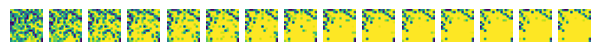

Epoch 0 | Step 100 | Loss: 0.1724027395248413 | C: Trouser


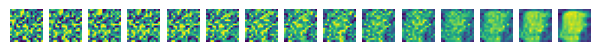

Epoch 0 | Step 200 | Loss: 0.12677980959415436 | C: Pullover


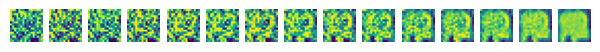

Epoch 0 | Step 300 | Loss: 0.13596117496490479 | C: Dress


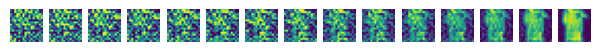

Epoch 0 | Step 400 | Loss: 0.10428750514984131 | C: Coat


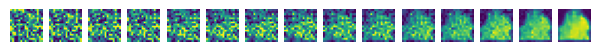

Epoch 0 | Step 500 | Loss: 0.1136588454246521 | C: Sandal


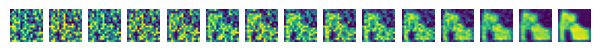

Epoch 1 | Step 000 | Loss: 0.11229267716407776 | C: Shirt


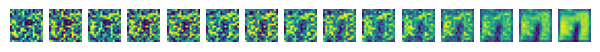

Epoch 1 | Step 100 | Loss: 0.10557614266872406 | C: Sneaker


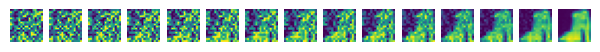

Epoch 1 | Step 200 | Loss: 0.09265733510255814 | C: Bag


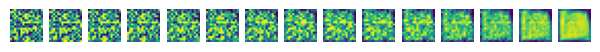

Epoch 1 | Step 300 | Loss: 0.10826060175895691 | C: Ankle boot


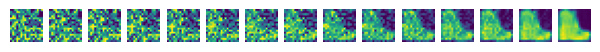

Epoch 1 | Step 400 | Loss: 0.0885310173034668 | C: Top


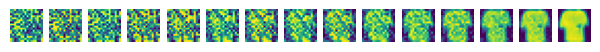

Epoch 1 | Step 500 | Loss: 0.13237765431404114 | C: Trouser


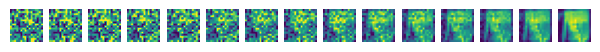

Epoch 2 | Step 000 | Loss: 0.09678438305854797 | C: Pullover


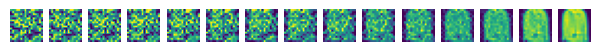

Epoch 2 | Step 100 | Loss: 0.11271049082279205 | C: Dress


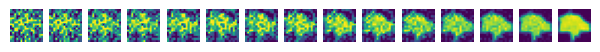

Epoch 2 | Step 200 | Loss: 0.11397808790206909 | C: Coat


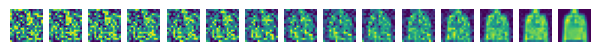

Epoch 2 | Step 300 | Loss: 0.08889245241880417 | C: Sandal


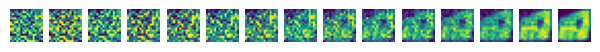

Epoch 2 | Step 400 | Loss: 0.10483692586421967 | C: Shirt


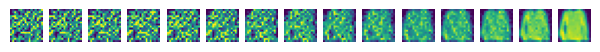

Epoch 2 | Step 500 | Loss: 0.09978757798671722 | C: Sneaker


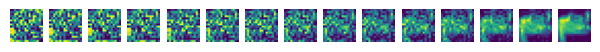

In [7]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 3
preview_c = 0

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        c_drop_prob = 0.1
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        c_hot, c_mask = get_context_mask(batch[1], c_drop_prob)  # New
        loss = ddpm.get_loss(model, x, t, c_hot, c_mask)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            class_name = class_names[preview_c]
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} | C: {class_name}")
            c_drop_prob = 0 # Do not drop context for preview
            c_hot, c_mask = get_context_mask(torch.Tensor([preview_c]), c_drop_prob)
            ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask)
            preview_c = (preview_c + 1) % N_CLASSES

How did it do? Try running the code cell below to see the final result for each class.

Top


<Figure size 800x800 with 0 Axes>

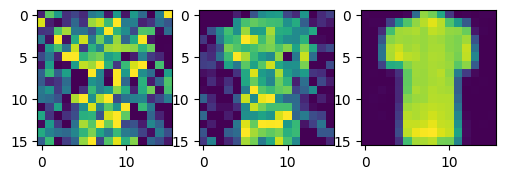

Trouser


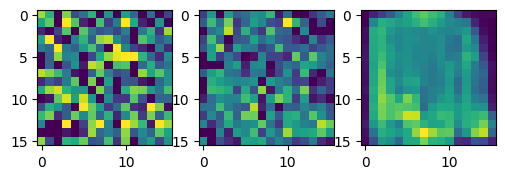

Pullover


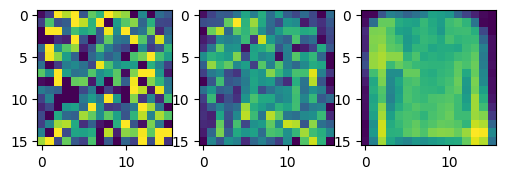

Dress


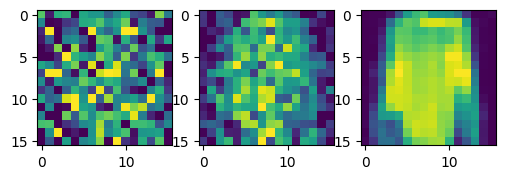

Coat


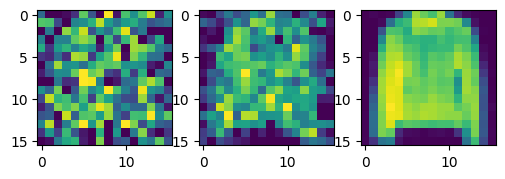

Sandal


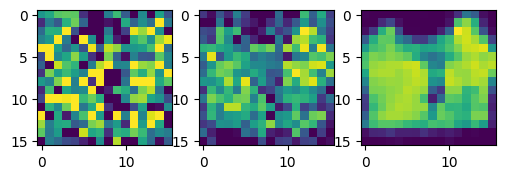

Shirt


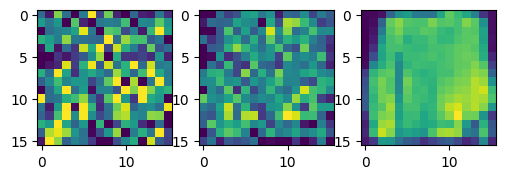

Sneaker


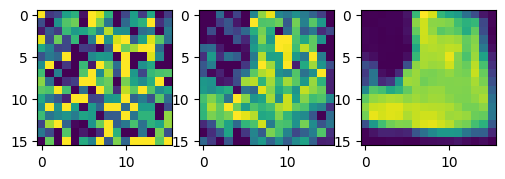

Bag


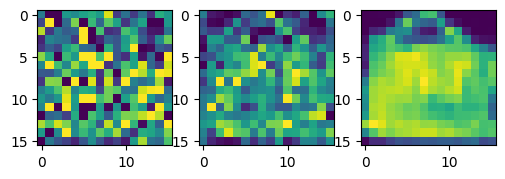

Ankle boot


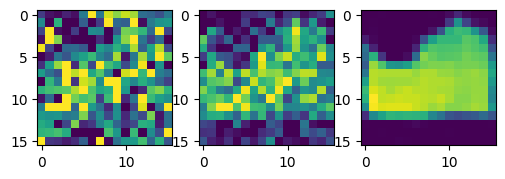

In [8]:
plt.figure(figsize=(8,8))
ncols = 3
c_drop_prob = 0 # Change me to a value between 1 and 0

for c in range(10):
    print(class_names[c])
    c_hot, c_mask = get_context_mask(torch.Tensor([c]), c_drop_prob)
    ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask, axis_on=True)

## 4.2 Conditioning Reverse Diffusion

Not bad, but not great either. Some of the classes are still influencing each other. For example, this shoe seems to have a shirt sleeve hanging off it.

<center><img src="images/shirt_shoe.png" alt="shirt_shoe" style="width: 400px;"/></center>

We can fix this by increasing the "weight" of the category. Here's the strategy:
* During the reverse diffusion process at each timestep, we will denoise the image **twice**
  * The first noise image we extract will **keep** its classifier information (`e_t_keep_c`)
  * The second noise image we extract will **drop** its classifier information (`e_t_drop_c`)
* We will subtract the average noise from the categorical noise using:
  * `e_t = (1 + w) * e_t_keep_c - w * e_t_drop_c`
  * where `w` is a weight value we choose as a hyperparameter
* We will use this new `e_t` noise to perform diffusion with `reverse_q`.
* Repeat the above steps from `t` = `T` to `0`

<center><img src="images/weighted_reverse_diffusion.png"/></center>

We've defined these steps in `sample_w` below. `sample_w` takes a list of noise weights so we can compare how it impacts the diffusion results.

In [9]:
@torch.no_grad()
def sample_w(
    model, input_size, T, c, w_tests=[-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0], store_freq=10
):
    # Preprase "grid of samples" with w for rows and c for columns
    n_samples = len(w_tests) * len(c)

    # One w for each c
    w = torch.tensor(w_tests).float().repeat_interleave(len(c))
    w = w[:, None, None, None].to(device)  # Make w broadcastable
    x_t = torch.randn(n_samples, *input_size).to(device)

    # One c for each w
    c = c.repeat(len(w_tests), 1)

    # Double the batch
    c = c.repeat(2, 1)

    # Don't drop context at test time
    c_mask = torch.ones_like(c).to(device)
    c_mask[n_samples:] = 0.0

    x_t_store = []
    for i in range(0, T)[::-1]:
        # Duplicate t for each sample
        t = torch.tensor([i]).to(device)
        t = t.repeat(n_samples, 1, 1, 1)

        # Double the batch
        x_t = x_t.repeat(2, 1, 1, 1)
        t = t.repeat(2, 1, 1, 1)

        # Find weighted noise
        e_t = model(x_t, t, c, c_mask)
        e_t_keep_c = e_t[:n_samples]
        e_t_drop_c = e_t[n_samples:]
        e_t = (1 + w) * e_t_keep_c - w * e_t_drop_c

        # Deduplicate batch for reverse diffusion
        x_t = x_t[:n_samples]
        t = t[:n_samples]
        x_t = ddpm.reverse_q(x_t, t, e_t)

        # Store values for animation
        if i % store_freq == 0 or i == T or i < 10:
            x_t_store.append(x_t)

    x_t_store = torch.stack(x_t_store)
    return x_t, x_t_store

Time to see it in action! Run the code below generate some articles of clothing and arrange them into a grid with [make_grid](https://pytorch.org/vision/main/generated/torchvision.utils.make_grid.html).

In [10]:
c = torch.arange(N_CLASSES).to(device)
c_drop_prob = 0  # Keep all category information for sampling
c_hot, c_mask = get_context_mask(c, c_drop_prob)
input_size = (IMG_CH, IMG_SIZE, IMG_SIZE)

x_0, x_t_store = sample_w(model, input_size, T, c_hot)

MovieWriter ffmpeg unavailable; using Pillow instead.


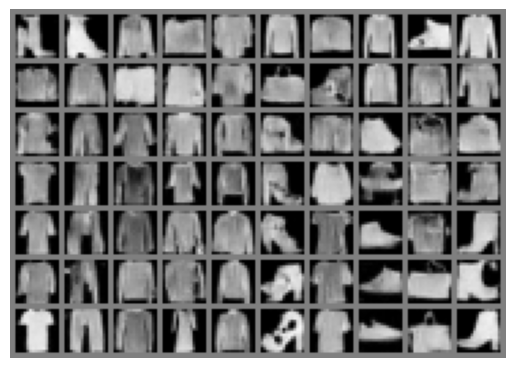

In [11]:
grids = [other_utils.to_image(make_grid(x_t.cpu(), nrow=N_CLASSES)) for x_t in x_t_store]
other_utils.save_animation(grids, "04_images/fashionMNIST.gif")

Click [here](04_images/fashionMNIST.gif) to see the animation of the reverse diffusion process that was just generated.

The rows represent increasing `w` values from `[-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]`. The first two rows are negative, meaning it stresses the average value of the model more than the categorical value. The model will sometimes generate completely different articles of clothing than was intended. The last few rows are consistent in generating items that match their label.

## 4.3 Modified TF Flowers

Congratulations on getting this far! You've mastered FashionMNIST, so now it's time for a bigger challenge: color images. For this challenge, we'll be using a modified version of the [TF Flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset.

These images have been slightly modified for the purpose of image generation. For example, this photo by user "_e.t" has been cropped to focus on the flower.

<center>
    <img src="images/24459750_eb49f6e4cb_m.jpg";/>
    <img src="data/cropped_flowers/sunflowers/24459750_eb49f6e4cb_m.jpg";/>
</center>

The model will take much longer to train because of this extra dimension of color. To speed things up, let's preload the images onto the GPU. If we [resize](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html) them before loading them onto our GPU, they will not take up much space.

We can use this technique because the dataset is relatively small. With a larger dataset, this may not be feasible to do.

To start, we should define the dataset variables:
* Image width and height `IMG_SIZE`
* Number of image channels `IMG_CH`
* Batch size `BATCH_SIZE`
* The size of the generated image `INPUT_SIZE` 

In [12]:
IMG_SIZE = 32
IMG_CH = 3
BATCH_SIZE = 128
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

In order to store the images on the GPU, we will have a list of `pre_transforms` that will run one time when we initialize our dataset. Then, the `random_transforms` will run on each batch when it is pulled from the dataset.

[Resize](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html) will resize an image so that the smaller edge between the width and height matches the size we specify. Then, we can use [RandomCrop](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomCrop.html) to both make the image square and effectively increase the size of our dataset with random data augmentation.

In [13]:
import torchvision
from torch.utils.data import Dataset, DataLoader

pre_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
])

random_transforms = transforms.Compose([
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
])

Next, let's develop a function to read in the image files. We'll use each image's parent directly to identify its label. We have three categories listed in `DATA_LABELS` below.

<center>
    <img src="data/cropped_flowers/daisy/14219214466_3ca6104eae_m.jpg";/>
    <img src="data/cropped_flowers/sunflowers/1240625276_fb3bd0c7b1.jpg";/>
    <img src="data/cropped_flowers/roses/14510185271_b5d75dd98e_n.jpg";/>
</center>

From left to right, we have a `daisy` by Allison Brown, a `sunflower` by Rob Young, and a `rose` by Matteo Accattino. The author for each photo is listed in [LICENSE.txt](data/cropped_flowers/LICENSE.txt)

Let's use the [glob](https://docs.python.org/3/library/glob.html) function to programmatically fetch the datapaths for each flower photo.

In [14]:
DATA_DIR = "data/cropped_flowers/"
DATA_LABELS = ["daisy", "sunflowers", "roses"]
N_CLASSES = len(DATA_LABELS)

data_paths = glob.glob(DATA_DIR + DATA_LABELS[0] + '/*.jpg', recursive=True)
data_paths[:5]  # First 5 paths

['data/cropped_flowers/daisy/3468498624_d082f99e98.jpg',
 'data/cropped_flowers/daisy/8382667241_0f046cecdb_n.jpg',
 'data/cropped_flowers/daisy/6095817094_3a5b1d793d.jpg',
 'data/cropped_flowers/daisy/8759177308_951790e00d_m.jpg',
 'data/cropped_flowers/daisy/7189043225_2fe781439a_n.jpg']

We can use pytorch's [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) tools in order to create our own dataset. `__init__` will run once when the class is initialized. `__getitem__` returns our images and labels while randomly applying our `random_transforms`.

In [15]:
class MyDataset(Dataset):
    def __init__(self):
        self.imgs = []
        self.labels = []
        
        for l_idx, label in enumerate(DATA_LABELS):
            data_paths = glob.glob(DATA_DIR + label + '/*.jpg', recursive=True)
            for path in data_paths:
                img = Image.open(path)
                self.imgs.append(pre_transforms(img).to(device))
                self.labels.append(l_idx)


    def __getitem__(self, idx):
        img = random_transforms(self.imgs[idx])
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.imgs)

train_data = MyDataset()
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Time to initialize our U-Net. It's the same as before, but our `T` is much larger as are our `down_chs`.

In [16]:
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = ddpm_utils.DDPM(B, device)

In [17]:
model_flowers = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=N_CLASSES
)
print("Num params: ", sum(p.numel() for p in model_flowers.parameters()))
model_flowers = torch.compile(model_flowers.to(device))

Num params:  44509443


Let's create a function to sample our diffusion model, so we can generate images during and after training.

In [18]:
def sample_flowers(n_classes):
    c_test = torch.arange(n_classes).to(device)
    c_hot_test, c_mask_test = get_context_mask(c_test, 0)
    x_gen, x_gen_store = sample_w(model_flowers, INPUT_SIZE, T, c_hot_test)
    return x_gen, x_gen_store

**TODO** Below is our new training loop. We've turned it into a function, but it's not complete yet. Each `FIXME` should be replaced with one of:
* `dataloader`
* `epochs`
* `n_classes`
* `c_drop_prob`

If needed, click the `...` for a solution.

In [19]:
def train_flowers(dataloader, epochs=100, n_classes=N_CLASSES, c_drop_prob=0.1, save_dir = "04_images/"):
    lrate = 1e-4
    optimizer = torch.optim.Adam(model_flowers.parameters(), lr=lrate)

    model_flowers.train()
    for epoch in range(FIXME):
        for step, batch in enumerate(FIXME):
            optimizer.zero_grad()
            t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
            x = batch[0].to(device)
            c_hot, c_mask = get_context_mask(batch[1], FIXME)
            loss = ddpm.get_loss(model_flowers, x, t, c_hot, c_mask)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
        if epoch % 5 == 0 or epoch == int(epochs - 1):
            x_gen, x_gen_store = sample_flowers(FIXME)
            grid = make_grid(x_gen.cpu(), nrow=n_classes)
            save_image(grid, save_dir + f"image_ep{epoch:02}.png")
            print("saved images in " + save_dir + f" for episode {epoch}")

In [20]:
def train_flowers(dataloader, epochs=100, n_classes=N_CLASSES, c_drop_prob=0.1, save_dir = "04_images/"):
    lrate = 1e-4
    optimizer = torch.optim.Adam(model_flowers.parameters(), lr=lrate)

    c = torch.arange(n_classes).to(device)
    c_hot_test, c_mask_test = get_context_mask(c, 0)

    model_flowers.train()
    for epoch in range(epochs):
        for step, batch in enumerate(dataloader):
            optimizer.zero_grad()
            t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
            x = batch[0].to(device)
            c_hot, c_mask = get_context_mask(batch[1], c_drop_prob)
            loss = ddpm.get_loss(model_flowers, x, t, c_hot, c_mask)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
        if epoch % 5 == 0 or epoch == int(epochs - 1):
            x_gen, x_gen_store = sample_flowers(n_classes)
            grid = make_grid(x_gen.cpu(), nrow=n_classes)
            save_image(grid, save_dir + f"image_ep{epoch:02}.png")
            print("saved images in " + save_dir + f" for episode {epoch}")

Moment of truth! Let's see how the diffusion model handles color images. The model will take about **fifteen minutes** to train. Once it starts training, grab a coffee, tea, or cozy beverage of choice. Then, check out the test outputs in the `04_images` directory. Flowers are recognizable at epoch 50, and the model will really hit its stride at epoch 100. It's fun to watch it learn.

In [21]:
train_flowers(dataloader)

Epoch 0 | Step 008 | Loss: 0.5338238477706909
saved images in 04_images/ for episode 0
Epoch 1 | Step 008 | Loss: 0.2453669011592865
Epoch 2 | Step 008 | Loss: 0.2007095217704773
Epoch 3 | Step 008 | Loss: 0.188937246799469
Epoch 4 | Step 008 | Loss: 0.15880703926086426
Epoch 5 | Step 008 | Loss: 0.16615620255470276
saved images in 04_images/ for episode 5
Epoch 6 | Step 008 | Loss: 0.1964823305606842
Epoch 7 | Step 008 | Loss: 0.13855156302452087
Epoch 8 | Step 008 | Loss: 0.18838272988796234
Epoch 9 | Step 008 | Loss: 0.1696178913116455
Epoch 10 | Step 008 | Loss: 0.13977567851543427
saved images in 04_images/ for episode 10
Epoch 11 | Step 008 | Loss: 0.1485450714826584
Epoch 12 | Step 008 | Loss: 0.1289132982492447
Epoch 13 | Step 008 | Loss: 0.15166668593883514
Epoch 14 | Step 008 | Loss: 0.13619159162044525
Epoch 15 | Step 008 | Loss: 0.1634678989648819
saved images in 04_images/ for episode 15
Epoch 16 | Step 008 | Loss: 0.09365057945251465
Epoch 17 | Step 008 | Loss: 0.10687164

Due to the random nature of diffusion models, some images will appear better than others. Try resampling until there is an output you'd like to keep as a souvenir. Then, run the cell afterwards to turn it into an animation.

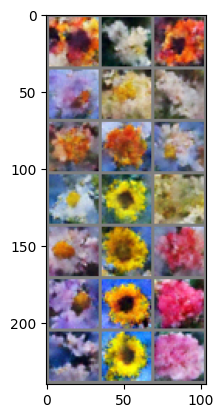

In [22]:
model.eval()
x_gen, x_gen_store = sample_flowers(N_CLASSES)
grid = make_grid(x_gen.cpu(), nrow=N_CLASSES)
other_utils.show_tensor_image([grid])
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


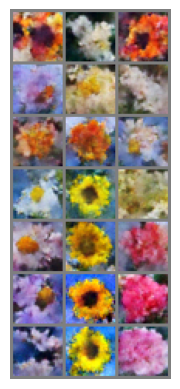

In [23]:
grids = [other_utils.to_image(make_grid(x_gen.cpu(), nrow=N_CLASSES)) for x_gen in x_gen_store]
other_utils.save_animation(grids, "04_images/flowers.gif")

## 4.4 Next

Not bad for a few minutes of training! In the next notebook, we'll make the results even better with a full text-to-image pipeline.

In [24]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>